## Think about Potential Energy

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import psu_tools

%matplotlib inline
cmap = 'viridis'


In [2]:
site = {'i': 53, 'j': 46}
mxk = 10
g = 9.8
maxdensity = 1023.0
mindensity = 999.7


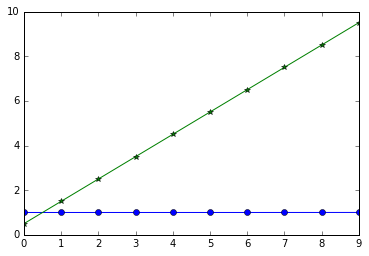

In [3]:
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
e3t = mesh.variables['e3t'][0, 0:mxk, 380+site['j'], 240+site['i']]
gdepT = mesh.variables['gdept'][0, 0:mxk, 380+site['j'], 240+site['i']]
maxdepth = np.sum(e3t)
plt.plot(e3t, '-o')
plt.plot(gdepT, '-*')


In [4]:
river_T_may = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')


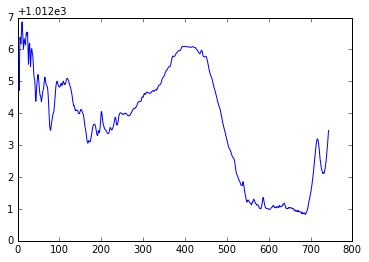

In [5]:
Sal = river_T_may.variables['vosaline'][:, 0:mxk, site['j'], site['i']]
Temp = river_T_may.variables['votemper'][:, 0:mxk, site['j'], site['i']]
Density = psu_tools.calculate_density(Temp, Sal)
average_Density = np.mean(Density, axis=1)
plt.plot(average_Density)


In [16]:
Density[-10,:]

array([ 1003.07141113,  1003.61682129,  1003.66790771,  1005.93066406,
        1014.20672607,  1022.34289551,  1022.33728027,  1022.33520508,
        1022.33374023,  1022.33416748], dtype=float32)

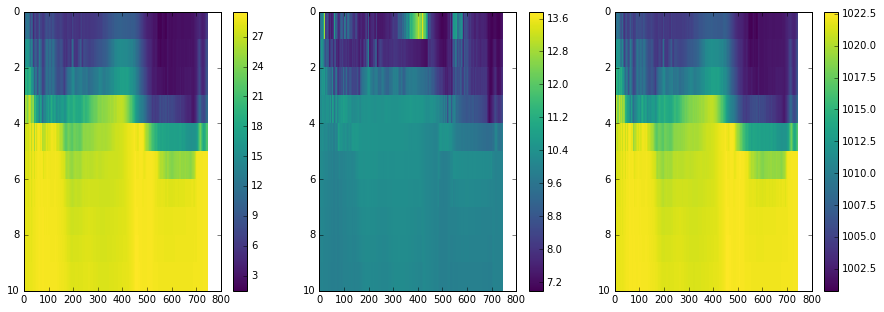

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, field in zip(axs, [Sal, Temp, Density]):
    mesh = ax.pcolormesh(field.T, cmap=cmap)
    ax.invert_yaxis()
    fig.colorbar(mesh, ax=ax)
    

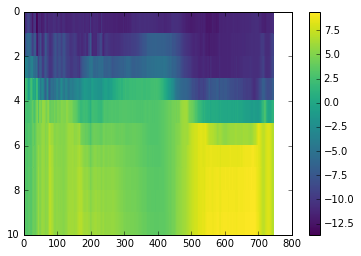

In [7]:
deldensity = Density - average_Density[:, None]
fig,ax = plt.subplots(1,1)
mesh = plt.pcolormesh(deldensity.T, cmap=cmap)
ax.invert_yaxis()
fig.colorbar(mesh)


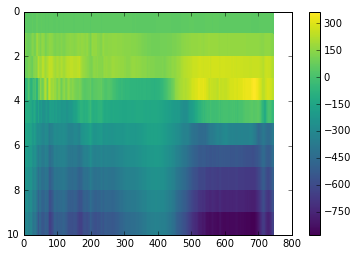

In [8]:
PE = -g * deldensity * gdepT * e3t
fig, ax = plt.subplots(1,1)
mesh = plt.pcolormesh(PE.T, cmap=cmap)
ax.invert_yaxis()
fig.colorbar(mesh)


Total unmixed means a layer of salinity 0 (density = mindensity= $\rho_o$, depth $\ell$) above a layer of salinity 30 (density = maxdensity = $\rho_1$). Total depth of the system is $D$

The average density ($\bar \rho$) of the this system must be the same as the average density of the model system

So $\bar \rho  D =  \rho_o \ell + \rho_1  (D - \ell)$

Thus $\ell = (\rho_1 - \bar \rho)/(\rho_1 - \rho_o) D$

The PE of this system =
$ - g (\rho_o - \bar \rho) \ell^2 /2 
  - g (\rho_1 - \bar \rho) (D - \ell) * (\ell + (D -\ell)/2.)$ 

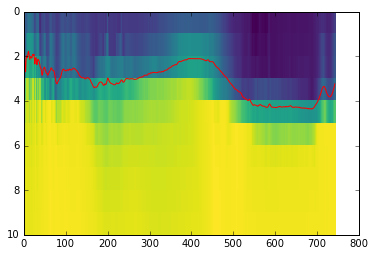

In [9]:
unmixed_ell = (maxdensity - average_Density)/(maxdensity - mindensity) * maxdepth
fig, ax = plt.subplots(1,1)
ax.pcolormesh(Density.T, cmap=cmap)
ax.plot(unmixed_ell, 'r')
ax.invert_yaxis()
unmixed_PE = (- 0.5 * g * (mindensity - average_Density) * unmixed_ell**2
              - 0.5 * g * (maxdensity - average_Density) * (maxdepth - unmixed_ell) * (maxdepth + unmixed_ell))


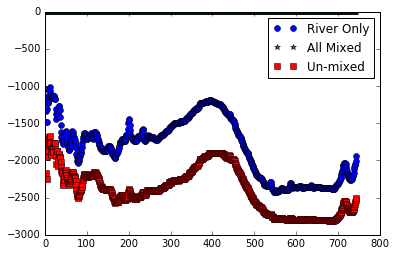

In [10]:
plt.plot(np.sum(PE, axis=1), 'o', label='River Only')
plt.plot(np.zeros(PE.shape[0]), '*', label='All Mixed')
plt.plot(unmixed_PE, 's', label='Un-mixed')
plt.legend()

In [17]:
def find_PE(filename):
    with nc.Dataset(filename) as data:
        Sal = data.variables['vosaline'][:, 0:mxk, site['j'], site['i']]
        Temp = data.variables['votemper'][:, 0:mxk, site['j'], site['i']]
    Density = psu_tools.calculate_density(Temp, Sal)
    average_Density = np.mean(Density, axis=1)
    deldensity = Density - average_Density[:, None]
    PE = -g * deldensity * gdepT * e3t
    unmixed_ell = (maxdensity - average_Density)/(maxdensity - mindensity) * maxdepth
    unmixed_PE = (- 0.5 * g * (mindensity - average_Density) * unmixed_ell**2
              - 0.5 * g * (maxdensity - average_Density) * (maxdepth - unmixed_ell) * (maxdepth + unmixed_ell))
    return np.sum(PE, axis=1), unmixed_PE


In [18]:
PE, unmixed = find_PE('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')

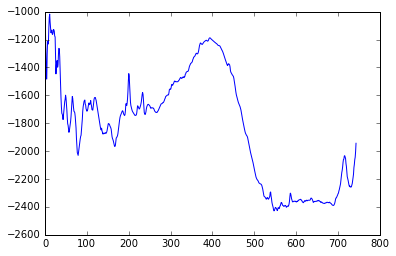

In [20]:
plt.plot(PE)

In [116]:
# graph commands
def make_pretty(fig, axs):
    for ax in axs:
        ax.legend()
        ax.set_ylabel('Potential Energy per m-squared ($kg s^{-1}$)')
        ax.set_xlabel('Hours in May')
    axs[0].set_title('Potential Energy Compared to a fully Mixed State')
    axs[1].set_title('Potential Energy Compared to a completely Unmixed State')


The average PE compared to an unmixed state for  all  is  883.583904478 kg/s
The average PE compared to an unmixed state for  onlyriver  is  573.304320004 kg/s
The average PE compared to an unmixed state for  winds  is  798.801840969 kg/s
The average PE compared to an unmixed state for  tides  is  756.070084941 kg/s


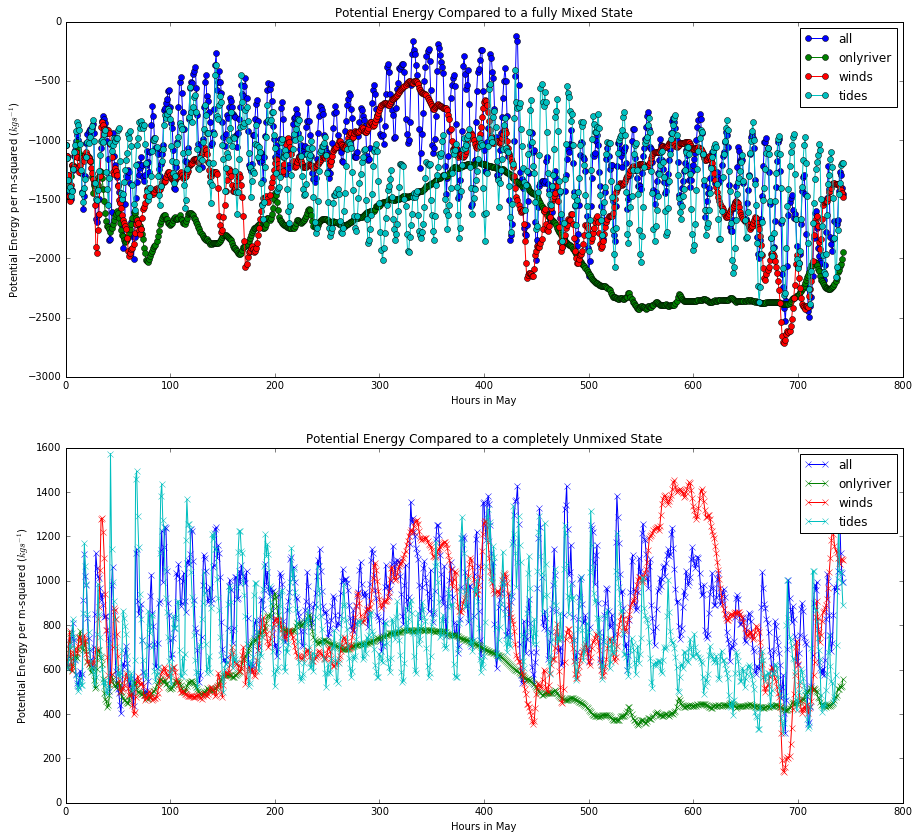

In [118]:
filenames = {'onlyriver': '/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc',
             'winds': '/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc',
             'tides': '/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc',
            'all': '/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc'}
fig, ax = plt.subplots(2, 1, figsize=(15, 14))
for filename in filenames:
    thePE, theunmixed = find_PE(filenames[filename])
    ax[0].plot(thePE, 'o-', label=filename)
    ax[1].plot(thePE - theunmixed, 'x-', label=filename)

    print ('The average PE compared to an unmixed state for ', filename, ' is ', np.mean(thePE-theunmixed), 'kg/s')
make_pretty(fig, ax)
